**Pitch Estimation**

This script performs the pitch estimation in two stages. First, CREPE is used for an intial pitch estimate. After that, on optimization method is used to improve the estimates accuracy and simultaniously extract the pitch derivative over time.

In [43]:
%load_ext autoreload
%autoreload 2

#hsvs includes
from hsvs.tools import dataset, crepe_estimate, framed_audio, pitch_optimize, magnitude
import hsvs

# 3rd party dependencies
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
vowel  = 'o'
singer = 'f4'

frame_config = { 
        'centered':True,
        'block-size':2048,
        'hop-size':64 }

pitch_estimate_config = {
        'iterations': 400,    # number of gradient descent iterations
        'batch-size': 4096,     # batch size for paralle prediction
        'pitch-rate': 0.1,      # gradient descent rate for pitch
        'pitch-inc-rate': 4000, # gradient descent rate for pitch inc
        'rate-decay':0.1}       # target rate factor after 'iterations' epoches.

# collecting sorce / output file paths 
source_file = dataset.get_sample('scales', 'slow_forte', vowel, singer)[0]
data_path   = os.path.abspath(os.path.join(os.path.dirname(hsvs.__file__), os.pardir, 'data'))
json_file   = os.path.join(data_path, 'results', vowel + '_' + singer, 'audio.json' )

**CREPE Estimate**

The initial pitch estimate is provided by CREPE and is later resampled to the required frame rate.

CREPE: A Convolutional Representation for Pitch Estimation  
Jong Wook Kim, Justin Salamon, Peter Li, Juan Pablo Bello.  
Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP), 2018.

In [37]:
# loading audio
audio = framed_audio.FramedAudio.from_file(source_file,  config=frame_config)

# running crepe estimation w/ octave error correciton
pitch_crepe = crepe_estimate.predict(audio)

2560/2560 [==============================] - 1s 358us/sample


**Optimization**

In the next step, the optimized pitch and pitch increment estimate is extracted using the initial estimate provided by CREPE. 
Pitch_optimize_gpu uses tensorflow to perform this task parallelized, optionally on a GPU. This step might take a while, a few minutes on a Nvidia RTX 2080 Super 

In [40]:
# running optimization / pitch & pitch increment estimation
pitch, pitch_inc = pitch_optimize.pitch_optimize_gpu(audio, pitch_estimate = pitch_crepe, options=pitch_estimate_config)

# store results as trajectories in audio object
audio.store_trajectory('pitch', pitch)
audio.store_trajectory('pitch-inc', pitch_inc)
audio.store_trajectory('crepe', pitch_crepe)

0%|          | 0/400 [00:00<?, ?it/s]
Running batch 1 of 3
  0%|          | 0/400 [00:00<?, ?it/s]
Running batch 2 of 3
  0%|          | 0/400 [00:00<?, ?it/s]
Running batch 3 of 3
100%|██████████| 400/400 [00:09<00:00, 42.93it/s, gradients=[0.011468437, 5.2525644e-05]]
Batch processing took 114.95032286643982 seconds



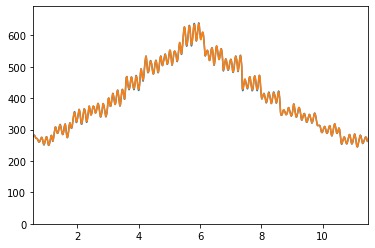

In [62]:
# plot pitch and pitch increment trajectories 
onset, offset = magnitude.get_onset_offset(audio)
plt.plot(audio.get_time(), audio.get_trajectory('pitch'), audio.get_time(), audio.get_trajectory('crepe'))
x1,x2,y1,y2 = plt.axis()
_,_,_,_ = plt.axis((onset*(audio.hop_size/audio.fs), offset*(audio.hop_size/audio.fs), y1, y2))
plt.show()


In [61]:
# store results
audio.save_json(json_file=json_file)